# Моделирование времен прихода

## Реализация

In [3]:
# Файл model_toa.py


import numpy as np
import matplotlib.pyplot as plt


class ModelTOA:
    def __init__(
        self,
        T: int,
        std_toa: float,
        time_start_jitter: float,
        signal_loss_rate: float,
        min_period: float,
        max_period: float,
        period_num: int,
        period_diff_threshold: float,
    ) -> None:
        """Класс моделирования времен прихода.

        Args:
            T (int): Длительность каждой пачки.
            std_toa (float): СКО времен прихода.
            time_start_jitter (float): Максимальный случайный сдвиг каждой пачки (равномерное распределение от 0 до этого значения).
            signal_loss_rate (float): Процент потерь сигналов.
            min_period (float): Минимальный период следования.
            max_period (float): Маскимальный период следования.
            period_num (int): Количество различных периодов следования (число источников).
            period_diff_threshold (int): Пороговое значение для разницы между периодами (разрешающая способность).
        """
        self.__T = T
        self.__std_toa = std_toa
        self.__time_start_jitter = time_start_jitter
        self.__signal_loss_rate = signal_loss_rate
        self.__period_diff_threshold = period_diff_threshold
        self.__period_array = self.__generate_unique_periods(
            min_period, max_period, period_num
        )

        self._toa_array = np.array([])
        self._labels = np.array([])
        self._sequence_lens = {}

    def __generate_unique_periods(
        self, min_period: float, max_period: float, period_num: int
    ) -> np.ndarray:
        periods = np.zeros(period_num)
        for i in range(period_num):
            while True:
                period = np.random.uniform(min_period, max_period)
                if all(abs(period - periods[:i]) > self.__period_diff_threshold):
                    periods[i] = period
                    break
        return np.sort(periods)

    def generate_toa(self) -> None:
        for i, period in enumerate(self.__period_array):
            time_arrival = np.arange(0, self.__T, period) + np.random.uniform(
                0, self.__time_start_jitter, 1
            )
            time_arrival += np.random.normal(0, self.__std_toa, len(time_arrival))

            mask = np.random.uniform(size=len(time_arrival)) >= self.__signal_loss_rate

            time_arrival = time_arrival[mask]
            label = np.ones(len(time_arrival)) * i
            self._labels = np.concatenate([self._labels, label])

            self._sequence_lens[i] = len(time_arrival)
            self._toa_array = np.concatenate([self._toa_array, time_arrival])

        self._labels = self._labels[np.argsort(self._toa_array)]
        self._toa_array = np.sort(self._toa_array)
        self._toa_array -= min(self._toa_array)

    def get_labels(self) -> np.ndarray:
        return self._labels

    def get_toa_array(self) -> np.ndarray:
        return self._toa_array

    def get_period_array(self) -> np.ndarray:
        return self.__period_array

    def get_std_toa(self) -> float:
        return self.__std_toa

    def get_T(self) -> int:
        return self.__T

    def get_signal_loss_rate(self) -> float:
        return self.__signal_loss_rate

    def draw_scatter_plot(self, start: int, end: int) -> None:
        plt.title("Диаграмма рассеяния времен прихода")
        plt.ylabel("Время прихода, с")
        plt.xlabel("Число отсчетов")

        unique_labels = np.unique(self._labels[start:end])
        colors = plt.get_cmap("viridis", len(unique_labels))(
            np.arange(len(unique_labels))
        )

        scatter = plt.scatter(
            x=np.arange(len(self._toa_array))[start:end],
            y=self._toa_array[start:end],
            c=self._labels[start:end],
            cmap="viridis",
        )

        legend_elements = [
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=colors[i],
                markersize=10,
                label=f"Period {int(label)}",
            )
            for i, label in enumerate(unique_labels)
        ]
        plt.legend(handles=legend_elements, title="Periods")

        plt.grid()
        plt.show()

## Использование

In [4]:
model_toa = ModelTOA(T=4,
                     std_toa=1e-6,
                     time_start_jitter=1e-2,
                     signal_loss_rate=0.3,
                     min_period=1e-3,
                     max_period=10e-3,
                     period_num=5,
                     period_diff_threshold=5e-5)
model_toa.generate_toa()

In [5]:
print(model_toa.get_labels())
print(model_toa.get_toa_array())
print(model_toa.get_period_array())

[4. 3. 2. ... 0. 0. 0.]
[0.00000000e+00 2.43025907e-04 8.08526526e-03 ... 4.00425862e+00
 4.00631913e+00 4.00837869e+00]
[0.00205956 0.00514204 0.00633664 0.0080503  0.00965175]


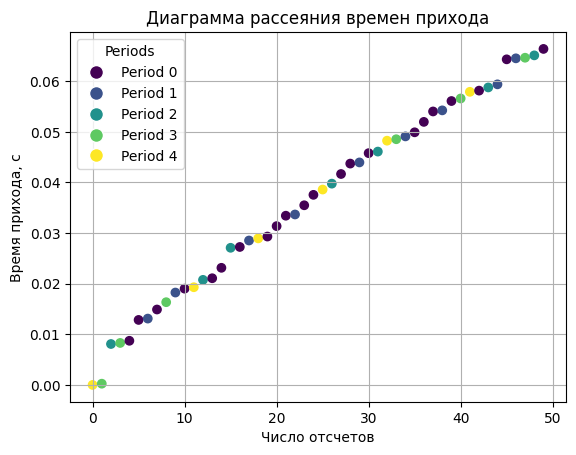

In [6]:
model_toa.draw_scatter_plot(0, 50)

# Обзор алгоритмов оценки количества источников по временам прихода

## Получение данных от модели

In [7]:
toa_array = model_toa.get_toa_array()
period_array = model_toa.get_period_array()
T = model_toa.get_T()
signal_loss_rate = model_toa.get_signal_loss_rate()
std_toa = model_toa.get_std_toa()

## Расчет матрицы разностей

In [8]:
# пороги по возможным периодам
min_period_threshold = 0.05e-3
max_period_threshold = 20e-3

In [9]:
diff_matrix = (toa_array - toa_array.reshape(-1,1))

diff_matrix[diff_matrix <= min_period_threshold] = -100
diff_matrix[diff_matrix >= max_period_threshold] = -100

phase_matrix = np.exp(1j * 2 * np.pi * (toa_array % diff_matrix) / diff_matrix)

diff = diff_matrix.flatten()
phase = phase_matrix.flatten()

diff_index = np.argwhere(diff > 0)
phase = phase[diff>0]
diff = diff[diff>0]
diff.shape

(43895,)

## Функция порогов PRI для гистограмм

In [10]:
def get_thresholds(period_array: np.ndarray, T: int, hist_n: int, signal_loss_rate: float, x: float, g: float):
    N = T * np.sum(1/period_array)
    B = len(hist_n)
    d = np.max(hist_n) - np.mean(hist_n)
    x *= signal_loss_rate
    thresholds = [x * (N - d) * np.exp(-1*(period)/g*B) for period in period_array]
    return np.array(thresholds)

## Delta-T гистограмма

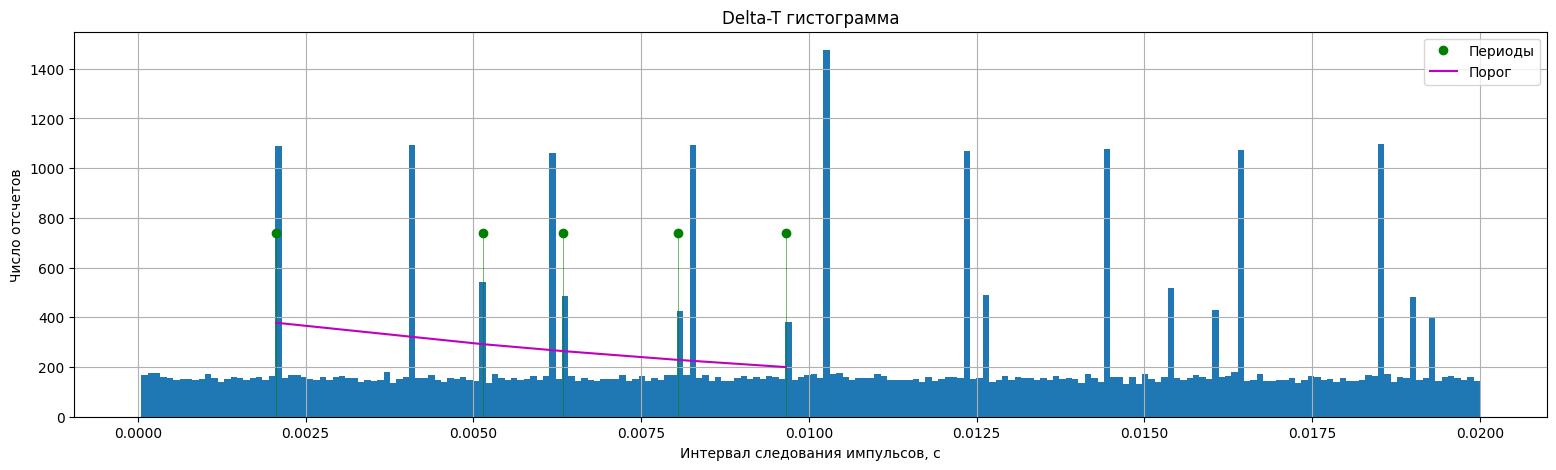

In [11]:
plt.figure(figsize=(19,5))
hist_res = plt.hist(diff, bins = 'sqrt')

thresholds = get_thresholds(period_array=period_array,
                            T=T,
                            hist_n=hist_res[0],
                            signal_loss_rate=signal_loss_rate,
                            x=0.5,
                            g=2.5)

plt.plot(period_array, [max(hist_res[0])*0.5] * len(period_array), 'go', label="Периоды")
plt.vlines(period_array, 0, max(hist_res[0])*0.5, 'g', linewidth=0.4)
plt.plot(period_array, thresholds, color='m', label='Порог')

plt.title('Delta-T гистограмма')
plt.xlabel('Интервал следования импульсов, с')
plt.ylabel('Число отсчетов')
plt.grid()
plt.legend()
plt.show()

## Комплексная Delta-T гистограмма

In [12]:
bin_edges = hist_res[1]
count = np.zeros(len(bin_edges), dtype = 'complex')
for ph, val in zip(phase, diff):
    ind = np.searchsorted(bin_edges, val, side='right') - 1
    count[ind] += ph
complex_amplitude = abs(count)

In [13]:
thresholds = get_thresholds(period_array=period_array,
                            T=T,
                            hist_n=hist_res[0],
                            signal_loss_rate=signal_loss_rate,
                            x=0.3,
                            g=2.0)

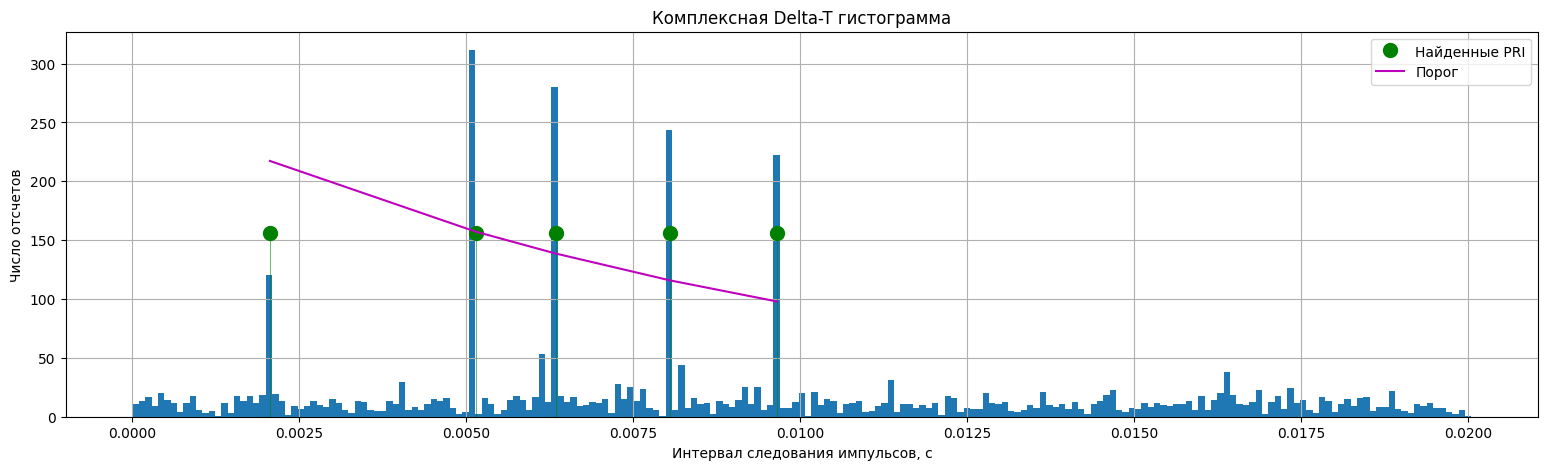

In [14]:
plt.figure(figsize=(19,5))

plt.bar(bin_edges, complex_amplitude, width=bin_edges[1]-bin_edges[0])
plt.plot(period_array, [max(complex_amplitude)*0.5] * len(period_array), 'go', markersize=10, label="Найденные PRI")
plt.vlines(period_array, 0, max(complex_amplitude)*0.5, 'g', linewidth=0.4)
plt.plot(period_array, thresholds, color='m', label='Порог')

plt.title('Комплексная Delta-T гистограмма')
plt.xlabel('Интервал следования импульсов, с')
plt.ylabel('Число отсчетов')
plt.grid()
plt.legend()
plt.show()

## Временное кодирование с быстрым преобразованием Фурье

In [15]:
from tqdm import tqdm

delta_t = 1e-6 # разрешение по времени

signal = np.zeros(int(max(toa_array) / delta_t)+2)
time_array = np.arange(0, max(toa_array)+delta_t, delta_t)

for toa in tqdm(toa_array):
    signal[np.searchsorted(time_array, toa, side='right')] = 1

print(f'\ntoa len: {len(toa_array)}')
print(f'time coding signal len: {len(signal)}')

100%|██████████| 3010/3010 [00:00<00:00, 111689.79it/s]


toa len: 3010
time coding signal len: 4008380


In [16]:
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), delta_t)
amplitude = np.abs(fft_result)
frequencies = frequencies[:len(frequencies)//2]
amplitude = amplitude[:len(amplitude)//2]
fs = 1 / delta_t
N = int((2 * len(amplitude)) / (fs * min_period_threshold) / 16)

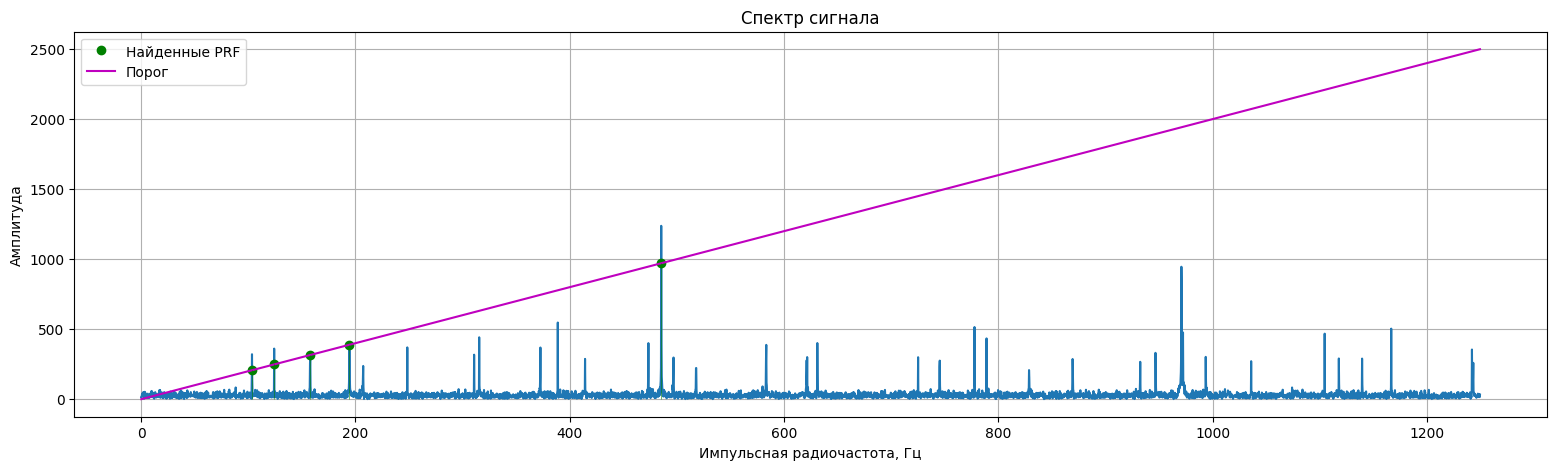

In [17]:
plt.figure(figsize=(19,5))
plt.plot(frequencies[1:N], amplitude[1:N])
plt.plot(1 / period_array, (T / period_array)*0.5, 'go', label="Найденные PRF")
plt.plot(frequencies[1:N], (T * frequencies[1:N])*0.5, 'm', label="Порог")
plt.vlines(1 / period_array, 0, (T / period_array)*0.5, 'g', linewidth=0.4)

plt.title('Спектр сигнала')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

## Прямое преобразование Фурье

In [18]:
np.ceil(np.log2(toa_array.shape))
toa_array.shape

(3010,)

In [19]:
signal_1 = np.sin(2 * np.pi * (toa_array) / (max(toa_array)))

n_fft = 2 ** int(np.ceil(np.log2(len(toa_array))))

fft_result = np.fft.fft(signal_1, n_fft)
frequencies = np.fft.fftfreq(n_fft, (max(toa_array)/(len(toa_array))))
amplitude = np.abs(fft_result)
frequencies = frequencies[:len(frequencies)//2]
amplitude = amplitude[:len(amplitude)//2]
fs = 1 / delta_t

Nmin = int(n_fft*0.02)
Nmax = -1

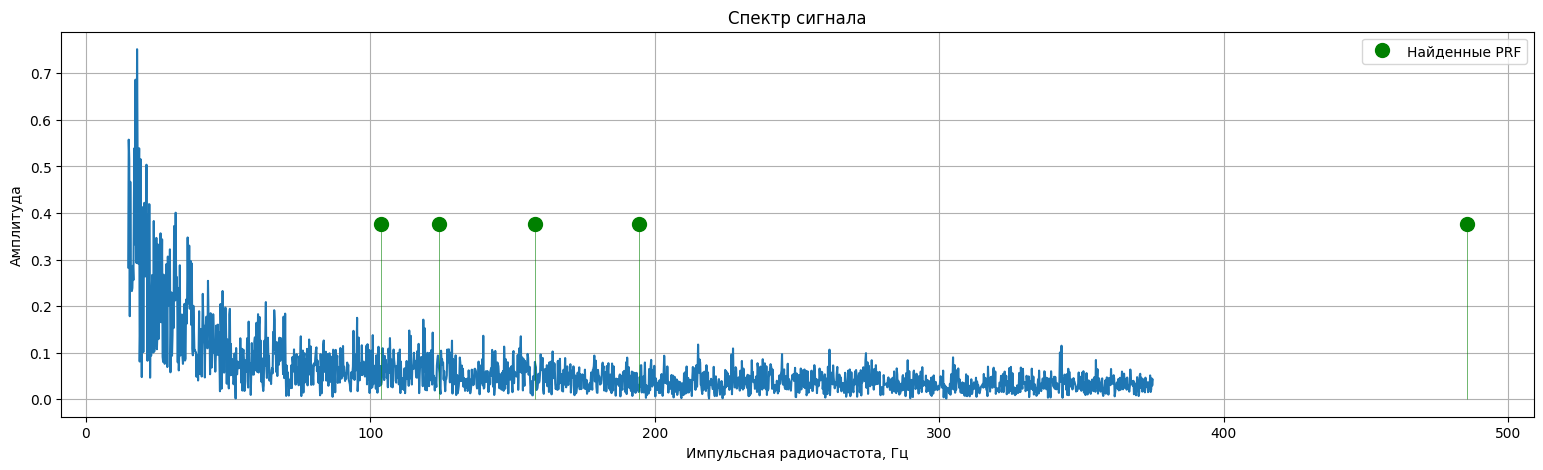

In [20]:
plt.figure(figsize=(19,5))
plt.plot(frequencies[Nmin:Nmax], amplitude[Nmin:Nmax])

plt.plot(1 / period_array, [max(amplitude[Nmin:Nmax])*0.5] * len(period_array), 'go', markersize=10, label="Найденные PRF")
plt.vlines(1 / period_array, 0, max(amplitude[Nmin:Nmax])*0.5, 'g', linewidth=0.4)
plt.title('Спектр сигнала')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

## Дельта-функция с прямым преобразованием Фурье

In [21]:
min_freq = 50
max_freq = 1000
frequencies = np.log(np.linspace(np.exp(min_freq/max_freq), np.exp(1), num = 8000)) * max_freq

amplitude = np.exp(1j * 2 * np.pi * frequencies * toa_array.reshape(-1,1))
amplitude = np.abs(np.sum(amplitude, axis=0))

alpha = 0.5

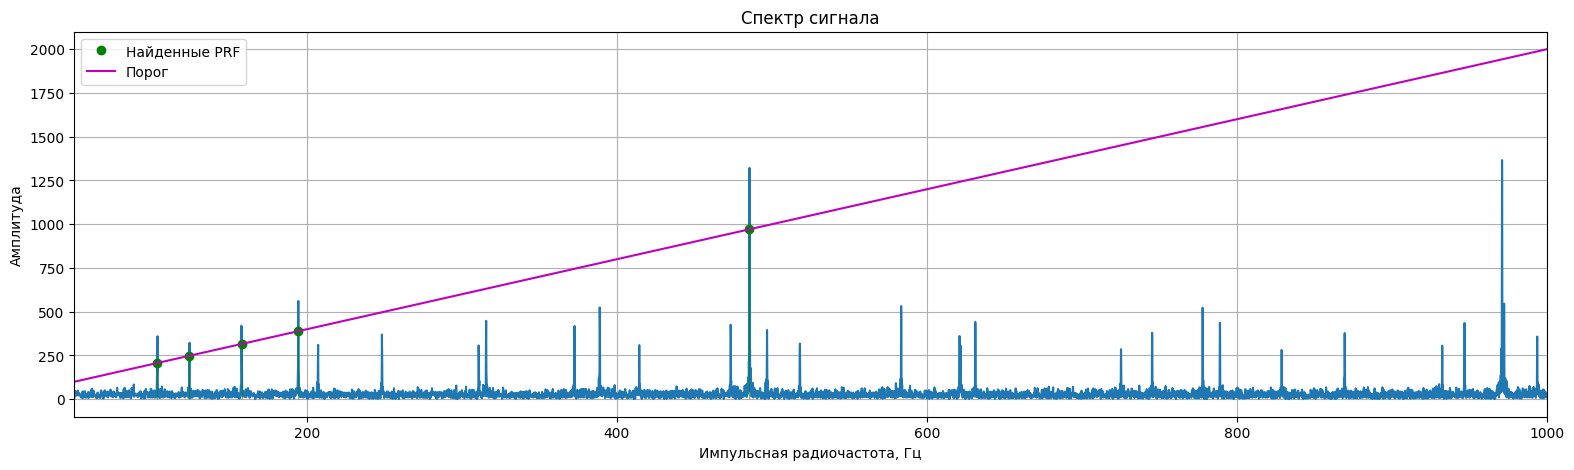

In [22]:
plt.figure(figsize=(19,5))
plt.plot(frequencies, amplitude)
plt.plot(1 / period_array, (T / period_array)*alpha, 'go', label="Найденные PRF")
plt.plot(frequencies, (T * frequencies)*alpha, 'm', label="Порог")
plt.vlines(1 / period_array, 0, (T / period_array)*0.5, 'g', linewidth=0.4)

plt.xlim(min_freq, max_freq)
plt.title('Спектр сигнала')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

In [23]:
PRF = frequencies[amplitude > (T * frequencies)*alpha]
amp = amplitude[amplitude > (T * frequencies)*alpha]
est_PRF = np.sort(PRF[np.argsort(amp)])
est_PRF

array([103.6453107 , 124.10189568, 124.28595845, 157.76761876,
       194.46302624, 485.50958872, 485.6378279 ])

# Функция устранения дубликатов найденных периодов следования

## Рассчёт PRF

In [24]:
min_freq = 50
max_freq = 1000
frequencies = np.log(np.linspace(np.exp(min_freq/max_freq), np.exp(1), num = 8000)) * max_freq

amplitude = np.exp(1j * 2 * np.pi * frequencies * toa_array.reshape(-1,1))
amplitude = np.abs(np.sum(amplitude, axis=0))

alpha = 0.5

PRF = frequencies[amplitude > (T * frequencies)*alpha]
amp = amplitude[amplitude > (T * frequencies)*alpha]
est_PRF = np.sort(PRF[np.argsort(amp)])
est_PRF

array([103.6453107 , 124.10189568, 124.28595845, 157.76761876,
       194.46302624, 485.50958872, 485.6378279 ])

## Реализация

In [25]:
def average_estimated_PRF(estimated_PRF: np.ndarray, averaging_threshold: float) -> np.ndarray:
    sorted_PRF = np.sort(estimated_PRF)

    grouped_PRF = []
    current_group = [sorted_PRF[0]]

    for i in range(1, len(sorted_PRF)):
        if abs(sorted_PRF[i] - sorted_PRF[i - 1]) < averaging_threshold:
            current_group.append(sorted_PRF[i])
        else:
            grouped_PRF.append(np.mean(current_group))
            current_group = [sorted_PRF[i]]

    grouped_PRF.append(np.mean(current_group))

    return np.array(grouped_PRF)

## Использование

In [26]:
averaged_PRF = average_estimated_PRF(estimated_PRF=est_PRF, averaging_threshold=5e-1)
print(averaged_PRF)
print(np.sort(1 / period_array))

[103.6453107  124.19392706 157.76761876 194.46302624 485.57370831]
[103.60820342 124.21902345 157.81225405 194.47530677 485.54168129]


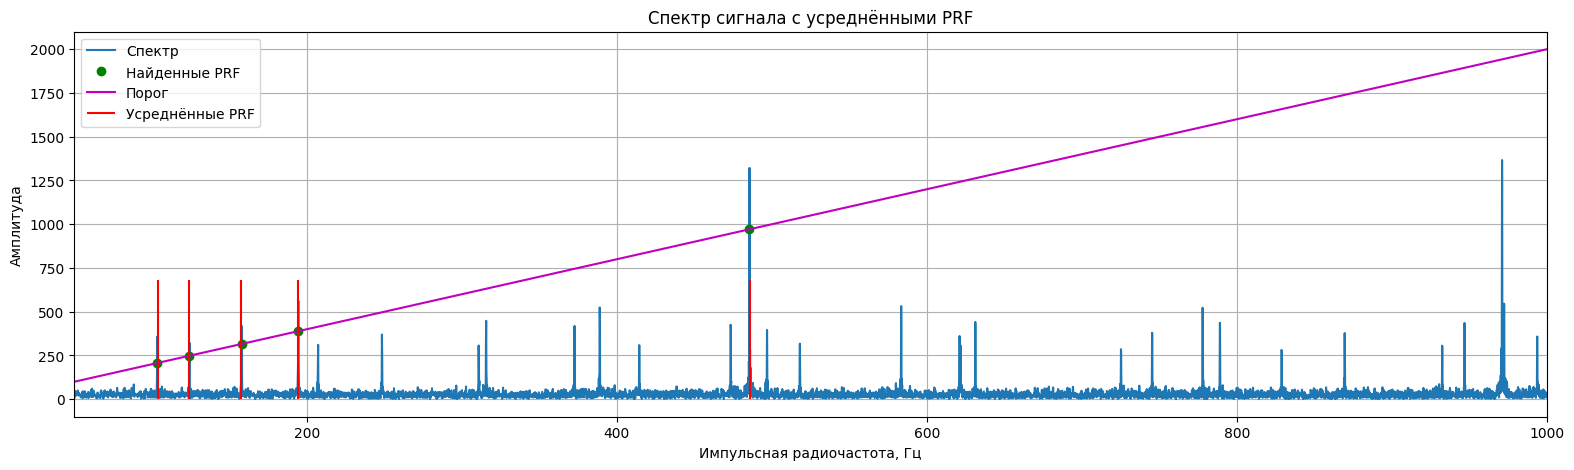

In [27]:
plt.figure(figsize=(19,5))
plt.plot(frequencies, amplitude, label='Спектр')
plt.plot(1 / period_array, (T / period_array)*alpha, 'go', label='Найденные PRF')
plt.plot(frequencies, (T * frequencies)*alpha, 'm', label='Порог')
plt.vlines(averaged_PRF, 0, max(amplitude)*0.5, 'r', linewidth=1.5, label='Усреднённые PRF')

plt.xlim(min_freq, max_freq)
plt.title('Спектр сигнала с усреднёнными PRF')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

In [28]:
PRI = np.sort(1 / averaged_PRF)

print(PRI)
print(np.sort(period_array))

[0.00205942 0.00514237 0.00633844 0.00805192 0.00964829]
[0.00205956 0.00514204 0.00633664 0.0080503  0.00965175]


# Программный модуль

## Получение данных от модели

In [29]:
toa_array = model_toa.get_toa_array()
period_array = model_toa.get_period_array()
T = model_toa.get_T()
signal_loss_rate = model_toa.get_signal_loss_rate()
std_toa = model_toa.get_std_toa()

## Реализация

In [30]:
# Файл parametric_signal_selection.py


import numpy as np
import matplotlib.pyplot as plt


class ParametricSignalSelector:
  def __init__(self,
               T: int,
               min_freq: int,
               max_freq: int,
               alpha_threshold: float,
               averaging_threshold: float) -> None:
        """Класс параметрической селекции сигналов.

        Args:
            T (int): Длительность каждой пачки.
            min_freq (int): Минимальная радиочастота.
            max_freq (float): Максимальная радиочастота.
            alpha_threshold (float): Порог для определения найденных радиочастот.
            averaging_threshold (float): Порог для усреднения найденных радиочастот.
        """
        self._T = T
        self._min_freq = min_freq
        self._max_freq = max_freq
        self._alpha = alpha_threshold
        self._averaging_threshold = averaging_threshold

  def __get_frequences(self) -> np.ndarray:
      return np.log(np.linspace(np.exp(self._min_freq/self._max_freq), np.exp(1), num = 8000)) * self._max_freq

  def __calculate_amplitude(self, frequencies: np.ndarray, toa_array: np.ndarray) -> np.ndarray:
      amplitude = np.exp(1j * 2 * np.pi * frequencies * toa_array.reshape(-1,1))
      amplitude = np.abs(np.sum(amplitude, axis=0))
      return amplitude

  def _estimate_PRF(self, toa_array: np.ndarray) -> np.ndarray:
      frequencies = self.__get_frequences()
      amplitude = self.__calculate_amplitude(frequencies, toa_array)

      PRF = frequencies[amplitude > (self._T * frequencies)*self._alpha]
      amp = amplitude[amplitude > (self._T * frequencies)*self._alpha]
      est_PRF = np.sort(PRF[np.argsort(amp)])
      return est_PRF

  def _average_estimated_PRF(self, estimated_PRF: np.ndarray) -> np.ndarray:
      sorted_PRF = np.sort(estimated_PRF)

      grouped_PRF = []
      current_group = [sorted_PRF[0]]

      for i in range(1, len(sorted_PRF)):
          if abs(sorted_PRF[i] - sorted_PRF[i - 1]) < self._averaging_threshold: # Нужен ли Махалонобис и как его применить?
              current_group.append(sorted_PRF[i])
          else:
              grouped_PRF.append(np.mean(current_group))
              current_group = [sorted_PRF[i]]

      grouped_PRF.append(np.mean(current_group))

      return np.array(grouped_PRF)

  def estimate_PRI(self, toa_array: np.ndarray) -> np.ndarray:
      estimated_PRF = self._estimate_PRF(toa_array)
      averaged_PRF = self._average_estimated_PRF(estimated_PRF)
      return np.sort(1 / averaged_PRF)

  def plot_signal_spectrum(self, period_array: np.ndarray, toa_array: np.ndarray) -> None:
      frequencies = self.__get_frequences()
      amplitude = self.__calculate_amplitude(frequencies, toa_array)
      estimated_PRF = self._estimate_PRF(toa_array)
      averaged_PRF = self._average_estimated_PRF(estimated_PRF)

      plt.figure(figsize=(19,5))
      plt.plot(frequencies, amplitude, label='Спектр')
      plt.plot(1 / period_array, (self._T / period_array)*self._alpha, 'go', label='Найденные PRF')
      plt.plot(frequencies, (self._T * frequencies)*self._alpha, 'm', label='Порог')
      plt.vlines(averaged_PRF, 0, max(amplitude)*0.5, 'r', linewidth=1.5, label='Усреднённые PRF')

      plt.xlim(self._min_freq, self._max_freq)
      plt.title('Спектр сигнала с усредненными PRF')
      plt.xlabel('Импульсная радиочастота, Гц')
      plt.ylabel('Амплитуда')
      plt.grid()
      plt.legend()
      plt.show()

## Использование

In [32]:
parametric_signal_selector = ParametricSignalSelector(T=T,
                                                      min_freq=50,
                                                      max_freq=1000,
                                                      alpha_threshold=5e-1,
                                                      averaging_threshold=5e-1)

In [33]:
PRI = parametric_signal_selector.estimate_PRI(toa_array)
print(PRI)
print(np.sort(period_array))

[0.00205942 0.00514237 0.00633844 0.00805192 0.00964829]
[0.00205956 0.00514204 0.00633664 0.0080503  0.00965175]


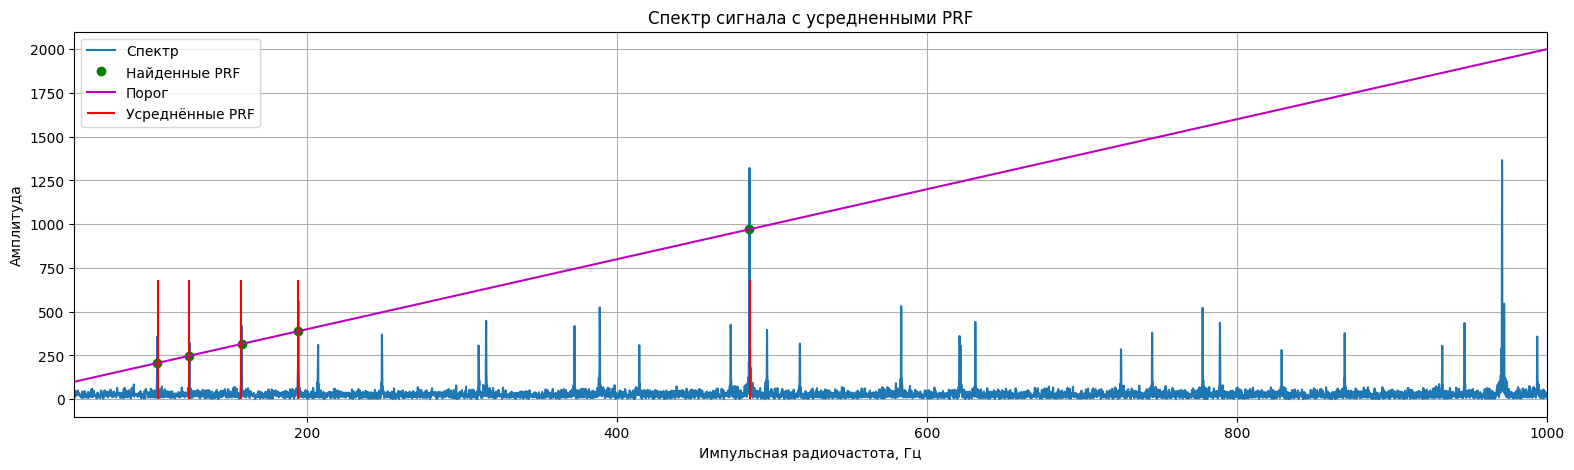

In [35]:
parametric_signal_selector.plot_signal_spectrum(
    period_array=period_array,
    toa_array=toa_array
)

# Функция метрики


## Реализация

In [36]:
# Файл metric.py

import numpy as np


def quality_metric(reference_PRI: np.ndarray, estimated_PRI: np.ndarray) -> float:
    """Используется расстояние Хаусдорффа для одномерных массивов"""
    directed_hausdorff_1d = lambda set1, set2: np.max([np.min([np.abs(x - y) for y in set2]) for x in set1])
    d1 = directed_hausdorff_1d(reference_PRI, estimated_PRI)
    d2 = directed_hausdorff_1d(estimated_PRI, reference_PRI)
    return max(d1, d2)

## Использование

In [37]:
print(quality_metric(period_array, PRI))

3.4555357144062937e-06


# Пайплайн для вариьрования параметров и оценки по метрике

In [38]:
# Файл pipeline.py

# import itertools
# import numpy as np
# import random
# import pandas as pd

# # from model import ModelTOA
# # from parametric_signal_selection import ParametricSignalSelector
# # from metric import quality_metric


# # Параметры для вариации
# param_ranges_toa = {
#     'T': [2, 6, 10],
#     'std_toa': [5e-7, 1e-6, 5e-6],
#     'time_start_jitter': [1e-3, 5e-3, 1e-2],
#     'signal_loss_rate': [0.1, 0.2, 0.3],
#     'min_period': [1e-3, 3e-3, 5e-3],
#     'max_period': [10e-3, 30e-3, 50e-3],
#     'period_num': [2, 6, 10],
#     'period_diff_threshold': [5e-5, 3e-5, 1e-5]
# } # TODO: фиксировать все и исследовать несколько наиболее важные параметры

# param_ranges_selector = {
#     'min_freq': [30, 50, 80],
#     'max_freq': [500, 1000, 1500],
#     'alpha_threshold': [0.1, 0.4, 0.7],
#     'averaging_threshold': [0.1, 0.4, 0.7]
# }

# # Генетический алгоритм
# population_size = 20
# generations = 5
# mutation_rate = 0.1

# def initialize_population(size):
#     population = []
#     for _ in range(size):
#         params_toa = [random.choice(param_ranges_toa[key]) for key in param_ranges_toa]
#         params_selector = [random.choice(param_ranges_selector[key]) for key in param_ranges_selector]
#         population.append((params_toa, params_selector))
#     return population

# def evaluate_fitness(individual):
#     params_toa, params_selector = individual
#     model_toa = ModelTOA(*params_toa)
#     model_toa.generate_toa()
#     toa_array = model_toa.get_toa_array()
#     period_array = model_toa.get_period_array()

#     parametric_signal_selector = ParametricSignalSelector(*params_selector)
#     PRI = parametric_signal_selector.estimate_PRI(toa_array)

#     metric_result = quality_metric(period_array, PRI)
#     return metric_result

# def select_parents(population, fitness):
#     sorted_population = [ind for _, ind in sorted(zip(fitness, population), key=lambda x: x[0])]
#     return sorted_population[:population_size // 2]

# def crossover(parents):
#     offspring = []
#     for _ in range(population_size):
#         parent1, parent2 = random.sample(parents, 2)
#         crossover_point_toa = random.randint(1, len(parent1[0]) - 1)
#         crossover_point_selector = random.randint(1, len(parent1[1]) - 1)
#         child_toa = parent1[0][:crossover_point_toa] + parent2[0][crossover_point_toa:]
#         child_selector = parent1[1][:crossover_point_selector] + parent2[1][crossover_point_selector:]
#         offspring.append((child_toa, child_selector))
#     return offspring

# def mutate(individual):
#     if random.random() < mutation_rate:
#         index_toa = random.randint(0, len(individual[0]) - 1)
#         individual[0][index_toa] = random.choice(list(param_ranges_toa.values())[index_toa])
#     if random.random() < mutation_rate:
#         index_selector = random.randint(0, len(individual[1]) - 1)
#         individual[1][index_selector] = random.choice(list(param_ranges_selector.values())[index_selector])

# # Основной цикл генетического алгоритма
# population = initialize_population(population_size)
# for generation in range(generations):
#     fitness = [evaluate_fitness(ind) for ind in population]
#     parents = select_parents(population, fitness)
#     population = crossover(parents)
#     for individual in population:
#         mutate(individual)

# # Оценка последнего поколения
# final_fitness = [evaluate_fitness(ind) for ind in population]
# sorted_population = sorted(zip(final_fitness, population), key=lambda x: x[0])

# # Получение 10 лучших и 10 худших результатов
# best_individuals = sorted_population[:10]
# worst_individuals = sorted_population[-10:]

# # Создание DataFrame для лучших результатов
# best_data = []
# for metric, (params_toa, params_selector) in best_individuals:
#     row = params_toa + params_selector + [metric]
#     best_data.append(row)

# best_columns = [
#     "T", "std_toa", "time_start_jitter", "signal_loss_rate",
#     "min_period", "max_period", "period_num", "period_diff_threshold",
#     "min_freq", "max_freq", "alpha_threshold", "averaging_threshold", "Metric"
# ]
# best_df = pd.DataFrame(best_data, columns=best_columns)

# # Создание DataFrame для худших результатов
# worst_data = []
# for metric, (params_toa, params_selector) in worst_individuals:
#     row = params_toa + params_selector + [metric]
#     worst_data.append(row)

# worst_df = pd.DataFrame(worst_data, columns=best_columns)

# # Вывод таблиц
# print("10 лучших результатов:")
# print(best_df)

# print("\n10 худших результатов:")
# print(worst_df)